# 模仿学习

虽然强化学习不需要有监督学习中的标签数据，**但它十分依赖奖励函数的设置。**

**有时在奖励函数上做一些微小的改动，训练出来的策略就会有天差地别。**

**在很多现实场景中，奖励函数并未给定，或者奖励信号极其稀疏，** 此时随机设计奖励函数将无法保证强化学习训练出来的策略满足实际需要。
- 例如，对于无人驾驶车辆智能体的规控，其观测是当前的环境感知恢复的 3D 局部环境，动作是车辆接下来数秒的具体路径规划，那么奖励是什么？如果只是规定正常行驶而不发生碰撞的奖励为+1，发生碰撞为-100，那么智能体学习的结果则很可能是找个地方停滞不前。**具体能帮助无人驾驶小车规控的奖励函数往往需要专家的精心设计和调试。**

**假设存在一个专家智能体，其策略可以看成最优策略**，我们就可以直接模仿这个专家在环境中交互的状态动作数据来训练一个策略，并且不需要用到环境提供的奖励信号。

**模仿学习（imitation learning）研究的便是这一类问题** ，
- 在模仿学习的框架下，专家能够提供一系列状态动作对${(s_t,a_t)}$，表示专家在$s_t$环境下做出了$a_t$的动作，而模仿者的任务则是利用这些专家数据进行训练，无须奖励信号就可以达到一个接近专家的策略。

目前学术界模仿学习的方法基本上可以分为 3 类：
- 行为克隆（behavior cloning，BC）
- 逆强化学习（inverse RL）
- 生成式对抗模仿学习（generative adversarial imitation learning，GAIL）

在本章将主要介绍行为克隆方法和生成式对抗模仿学习方法。

**尽管逆强化学习有良好的学术贡献，但由于其计算复杂度较高，实际应用的价值较小。**

## 行为克隆

行为克隆（BC）就是直接使用监督学习方法，将专家数据中$(s_t,a_t)$的:
- $s_t$看作样本输入，
- $s_t$视为标签，

学习的目标为
$ θ^* = argmin_θ{E_{(s,a)∼B}{[L(π_θ(s),a)]}}$

- B是专家的数据集，
- L是对应监督学习框架下的**损失函数**。
    - 若动作是离散的，该损失函数可以是最大似然估计得到的。
    - 若动作是连续的，该损失函数可以是均方误差函数。

在训练数据量比较大的时候，BC 能够很快地学习到一个不错的策略。
- 例如，围棋人工智能 AlphaGo 就是首先在 16 万盘棋局的 3000 万次落子数据中学习人类选手是如何下棋的，仅仅凭这个行为克隆方法，AlphaGo 的棋力就已经超过了很多业余围棋爱好者。

**由于 BC 的实现十分简单，因此在很多实际场景下它都可以作为策略预训练的方法**。

**BC 能使得策略无须在较差时仍然低效地通过和环境交互来探索较好的动作，而是通过模仿专家智能体的行为数据来快速达到较高水平，为接下来的强化学习创造一个高起点。**

**BC 也存在很大的局限性**
- 该局限在数据量比较小的时候犹为明显。

具体来说，由于通过 BC 学习得到的策略只是拿小部分专家数据进行训练，因此 BC 只能在专家数据的状态分布下预测得比较准。

然而，强化学习面对的是一个序贯决策问题，**通过 BC 学习得到的策略在和环境交互过程中不可能完全学成最优，只要存在一点偏差，就有可能导致下一个遇到的状态是在专家数据中没有见过的。**

此时，由于没有在此状态（或者比较相近的状态）下训练过，策略可能就会随机选择一个动作，这会导致下一个状态进一步偏离专家策略遇到的的数据分布。最终，该策略在真实环境下不能得到比较好的效果，这被称为行为**克隆的复合误差（compounding error）问题**，如图 15-1 所示。

In [1]:
from IPython.display import Image

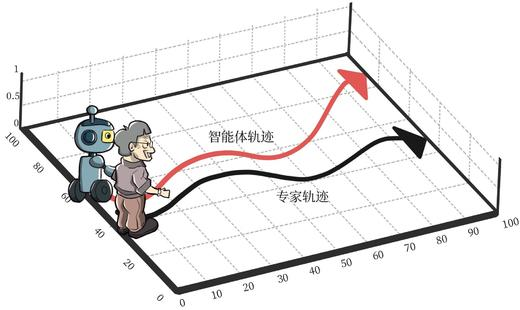

In [2]:
Image(filename='./image/bc.png',width=600)

## 生成式对抗模仿学习

**生成式对抗模仿学习（generative adversarial imitation learning，GAIL）** 是 2016 年由斯坦福大学研究团队提出的基于生成式对抗网络的模仿学习，**它诠释了生成式对抗网络的本质其实就是模仿学习**。


GAIL 实质上是模仿了专家策略的占用度量$p_E{(s,a)}$，即尽量使得策略在环境中的所有状态动作对(s,a)的占用度量$p_π{(s,a)}$和专家策略的占用度量一致。

**为了达成这个目标，策略需要和环境进行交互，收集下一个状态的信息并进一步做出动作** 。这一点和 BC 不同，**BC 完全不需要和环境交互。**


GAIL 算法中**有一个判别器和一个策略**，
- 策略就相当于是生成式对抗网络中的生成器（generator），给定一个状态，策略会输出这个状态下应该采取的动作，
- 判别器（discriminator）D将状态动作(s,a)对作为输入，**输出一个 0 到 1 之间的实数，表示判别器认为该状态动作对(s,a)是来自智能体策略而非专家的概率**。

判别器D的目标是尽量将**专家数据的输出靠近 0**，将**模仿者策略的输出靠近 1**，这样就可以将两组数据分辨开来。

于是，**判别器的损失函数为:**

$L(ϕ) = -E_{p_π}[logD_ϕ{(s,a)}] - E_{p_E}[log(1-D_ϕ{(s,a)})]$

- ϕ是判别器D的参数
有了判别器D之后，**模仿者策略的目标就是其交互产生的轨迹能被判别器误认为专家轨迹**。于是，**我们可以用判别器D的输出来作为奖励函数来训练模仿者策略**

**具体来说:**
若模仿者策略在环境中采样到状态s，并且采取动作a，
- (s,a)会输入到判别器D中，输出D(s,a)的值，
- 然后将奖励设置为$r(s,a) = -logD(s,a)$。

于是，我们可以用任意强化学习算法，使用这些数据继续训练模仿者策略。

**最后，在对抗过程不断进行后，(模仿者策略生成的数据分布)-->将接近-->(真实的专家数据分布)，达到模仿学习的目标**。

GAIL 的优化目标如图 15-2 所示。



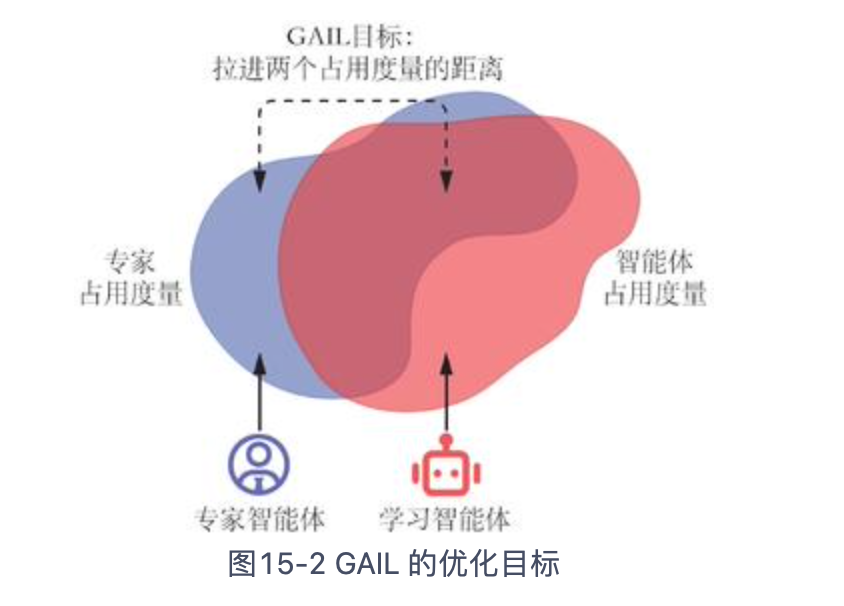

In [3]:
Image(filename='./image/gail.png',width=600)

第 3 章介绍过**一个策略和给定 MDP 交互的占用度量呈一一对应的关系**。

因此，**模仿学习的本质就是通过更新策略使其占用度量尽量靠近专家的占用度量，而这正是 GAIL 的训练目标**。

**由于一旦策略改变，其占用度量就会改变，因此为了训练好最新的判别器，策略需要不断和环境做交互，采样出最新的状态动作对样本。**



In [ ]:
import gym
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import rl_utils

In [2]:

class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class PPO:
    ''' PPO算法,采用截断方式 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs  # 一条序列的数据用于训练轮数
        self.eps = eps  # PPO中截断范围的参数
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1, 1).to(self.device)
        
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -dones)
        td_delta = td_target - self.critic(states)
        
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda,td_delta.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1,actions)).detach()

        for _ in range(self.epochs):
            log_probs = torch.log(self.actor(states).gather(1, actions))
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps,1 + self.eps) * advantage  # 截断
            actor_loss = torch.mean(-torch.min(surr1, surr2))  # PPO损失函数
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            
            actor_loss.backward()
            critic_loss.backward()
            
            self.actor_optimizer.step()
            self.critic_optimizer.step()


actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 250
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name)
env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

ppo_agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,epochs, eps, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, ppo_agent, num_episodes)

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/opt/miniconda3/envs/gym3.10.0/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


AttributeError: 'CartPoleEnv' object has no attribute 'seed'

**接下来开始生成专家数据。**

因为车杆环境比较简单，我们只生成一条轨迹，并且从中采样 30 个状态动作对样本(s,a)。

我们只用这 30 个专家数据样本来训练模仿策略。

In [ ]:
def sample_expert_data(n_episode):
    states = []
    actions = []
    for episode in range(n_episode):
        state = env.reset()
        done = False
        while not done:
            action = ppo_agent.take_action(state)
            states.append(state)
            actions.append(action)
            next_state, reward, done, _ = env.step(action)
            state = next_state
    return np.array(states), np.array(actions)


env.seed(0)
torch.manual_seed(0)
random.seed(0)
n_episode = 1

# 专家数据
expert_s, expert_a = sample_expert_data(n_episode)

n_samples = 30  # 采样30个数据

random_index = random.sample(range(expert_s.shape[0]), n_samples)
expert_s = expert_s[random_index]
expert_a = expert_a[random_index]

## 行为克隆的代码实践

在 BC 中，我们将专家数据中的$(s_t,a_t)$中的$s_t$视为标签，

BC 则转化成监督学习中经典的分类问题，采用最大似然估计的训练方法可得到分类结果。

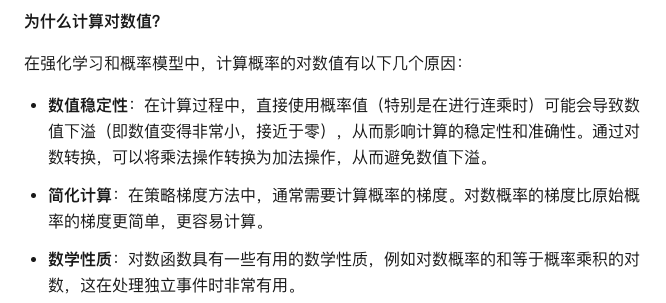

In [4]:
Image(filename='./image/log.png',width=600)

In [6]:
import torch
import torch.nn.functional as F

# 假设策略模型输出两个动作的概率
policy_output = torch.tensor([[0.7, 0.3], [0.4, 0.6]])

# 假设我们选择的动作索引
actions = torch.tensor([[0, 1]])

# 提取动作概率
action_probs = policy_output.gather(1, actions).squeeze()

# 计算对数概率
log_probs = torch.log(action_probs)

print("Action probabilities:", action_probs)
print("Log probabilities:", log_probs)

Action probabilities: tensor([0.7000, 0.3000])
Log probabilities: tensor([-0.3567, -1.2040])


In [ ]:
class BehaviorClone:
    def __init__(self, state_dim, hidden_dim, action_dim, lr):
        self.policy = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)

    def learn(self, states, actions):
        states = torch.tensor(states, dtype=torch.float).to(device)
        actions = torch.tensor(actions).view(-1, 1).to(device)
        
        # 计算对数概率
        # 首先，通过调用 self.policy(states) 计算在给定状态下采取每个可能动作的概率分布。
        # 然后，使用 .gather(1, actions) 从这些概率分布中提取出实际采取的动作的概率。
        log_probs = torch.log(self.policy(states).gather(1, actions))
        
        # 这是最大似然估计的损失函数，用于衡量策略在给定状态下采取特定动作的表现
        bc_loss = torch.mean(-log_probs)  # 最大似然估计

        self.optimizer.zero_grad()
        bc_loss.backward()
        self.optimizer.step()

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(device)
        probs = self.policy(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()


def test_agent(agent, env, n_episode):
    return_list = []
    for episode in range(n_episode):
        episode_return = 0
        state = env.reset()
        done = False
        while not done:
            action = agent.take_action(state)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            episode_return += reward
        return_list.append(episode_return)
    return np.mean(return_list)


env.seed(0)
torch.manual_seed(0)
np.random.seed(0)

lr = 1e-3
bc_agent = BehaviorClone(state_dim, hidden_dim, action_dim, lr)
n_iterations = 1000
batch_size = 64
test_returns = []

with tqdm(total=n_iterations, desc="进度条") as pbar:
    for i in range(n_iterations):
        sample_indices = np.random.randint(low=0,high=expert_s.shape[0],size=batch_size)
        # 通过采样的专家数据来学习
        bc_agent.learn(expert_s[sample_indices], expert_a[sample_indices])
        
        current_return = test_agent(bc_agent, env, 5)
        test_returns.append(current_return)
        
        if (i + 1) % 10 == 0:
            pbar.set_postfix({'return': '%.3f' % np.mean(test_returns[-10:])})
        pbar.update(1)

In [ ]:
iteration_list = list(range(len(test_returns)))
plt.plot(iteration_list, test_returns)
plt.xlabel('Iterations')
plt.ylabel('Returns')
plt.title('BC on {}'.format(env_name))
plt.show()

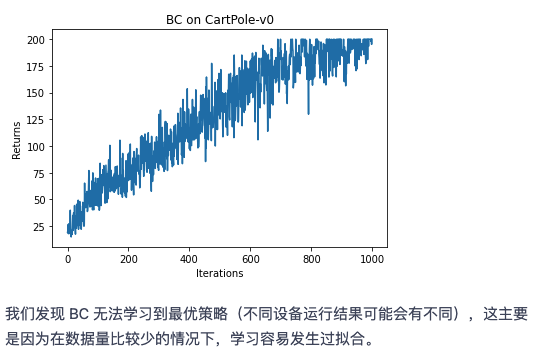

In [5]:
Image(filename='./image/bc_chart2.png',width=600)

 ### 生成式对抗模仿学习的代码实践
 
 首先**实现判别器模型**，其模型架构为一个两层的全连接网络，
 - 输入为:一个状态动作对(s,a)，
 - 输出:一个概率标量。

In [1]:
class Discrimininator:
    def __init__(self,state_dim,hidden_dim,action_dim):
        super(Discrimininator,self).__init__()
        self.fc1 = torch.nn.Linear(state_dim+action_dim,hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim,1)
    def forward(self,x,a):
        cat = torch.concat([x,a],dim=1)
        x = F.relu(self.fc1(cat))
        return torch.sigmoid(self.fc2(x))

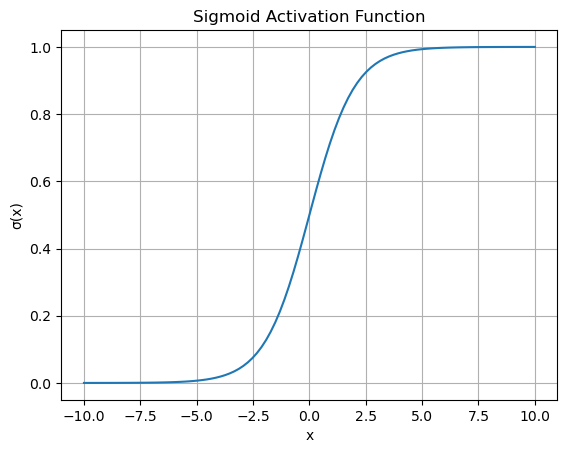

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# 定义sigmoid函数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# 生成x值
x = np.linspace(-10, 10, 100)

# 计算对应的sigmoid值
y = sigmoid(x)

# 绘制图形
plt.plot(x, y)
plt.title('Sigmoid Activation Function')
plt.xlabel('x')
plt.ylabel('σ(x)')
plt.grid(True)
plt.show()

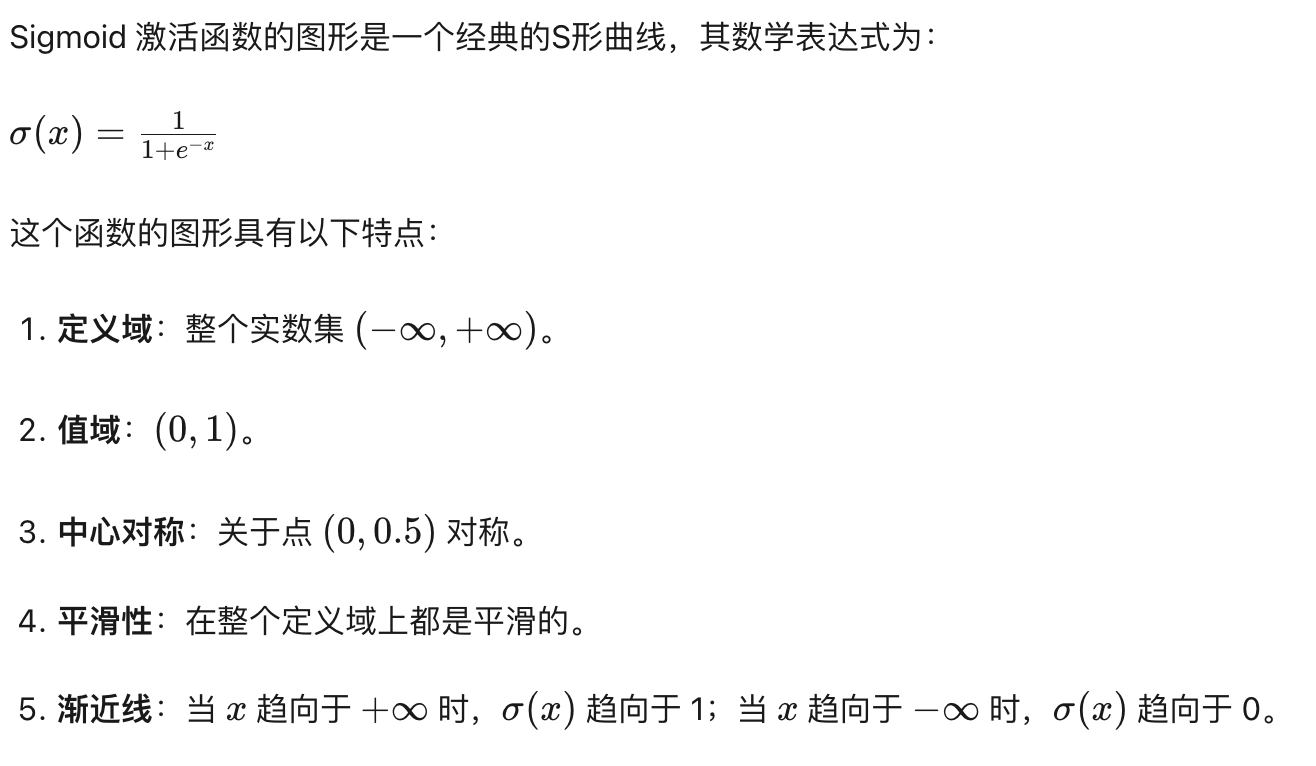

In [6]:
Image(filename='./image/sigmoid.png',width=600)

**接下来正式实现 GAIL 的代码。**

- 每一轮迭代中，GAIL 中的策略和环境交互，采样新的状态动作对。

- 基于专家数据和策略新采样的数据，
    - 首先训练判别器，
    - 然后将判别器的输出转换为策略的奖励信号，指导策略用 PPO 算法做训练。


In [4]:
import torch
import torch.nn as nn

# 示例数据
agent_prob_test = torch.tensor([0.9, 0.8, 0.7, 0.6])
expert_prob_test = torch.tensor([0.1, 0.2, 0.3, 0.4])

# 计算损失
bce_loss_test = nn.BCELoss()
discriminator_loss_test = bce_loss_test(agent_prob_test, torch.ones_like(agent_prob_test)) + bce_loss_test(expert_prob_test, torch.zeros_like(expert_prob_test))

print(discriminator_loss_test)

tensor(0.5980)


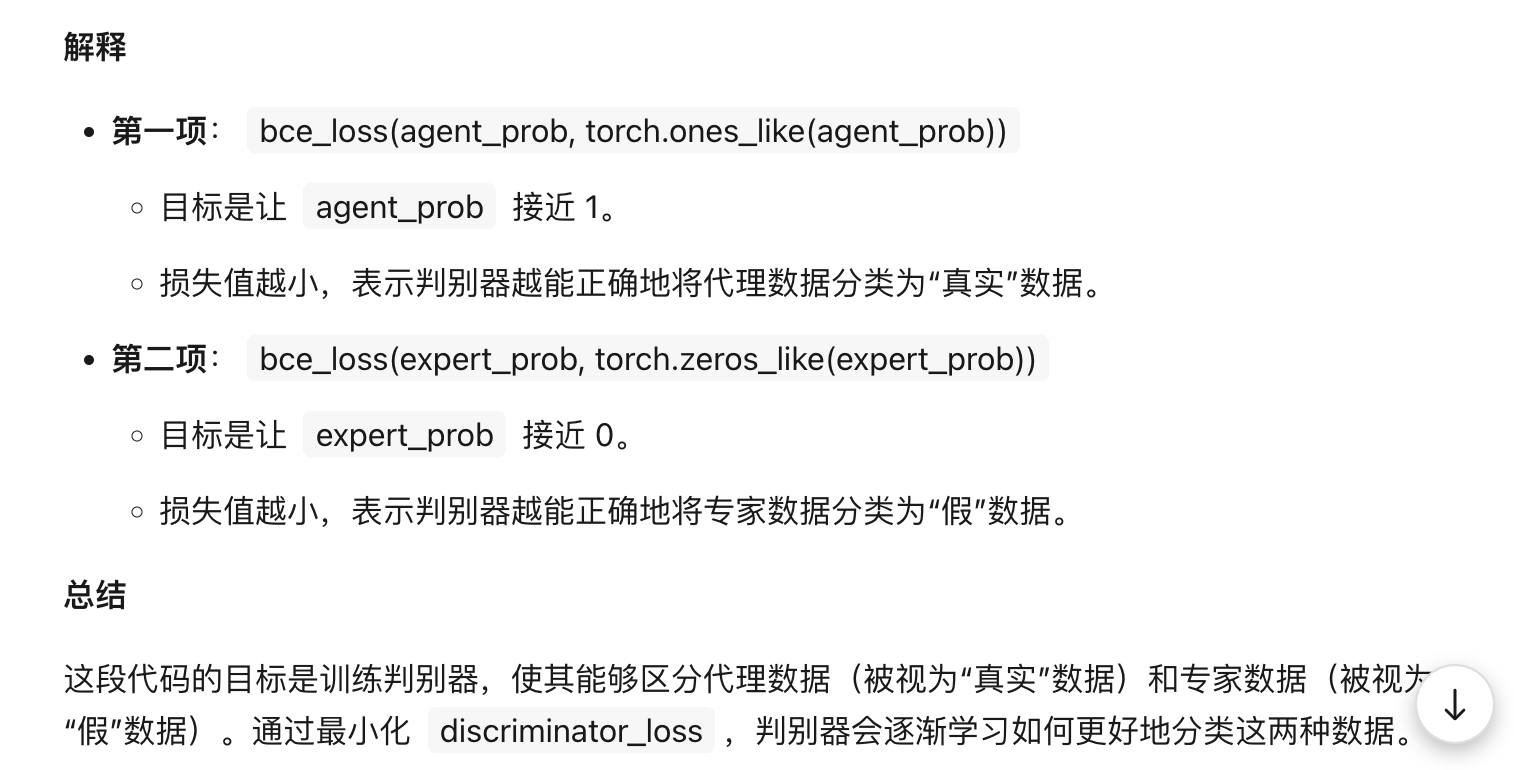

In [7]:
Image(filename='./image/bce_loss.png',width=600)

In [ ]:
class GAIL:
    def __init__(self,agent,state_dim,action_dim,hidden_dim,lr_d):
        self.discriminiator = Discrimininator(state_dim,hidden_dim,action_dim).to(device)
        self.discriminiator_optimizer = torch.optim.Adam(self.discriminiator.parameters(),lr = lr_d)
        self.agent = agent
        
    def learn(self,expert_s,expert_a,agent_s,agent_a,next_s,dones):
        expert_states = torch.tensor(expert_s,dtype=torch.float).to(device)
        expert_actions = torch.tensor(expert_a,dtype=torch.float).to(device)
        
        agent_states = torch.tensor(agent_s,dtype=torch.float).to(device)
        agent_actions = torch.tensor(agent_actions,dtype=torch.float).to(device)
        
        expert_actions = F.one_hot(expert_actions,num_classes = 2).float()
        agent_actions = F.one_hot(agent_actions,num_classes=2).float()
        
        # expert_prob 是判别器对专家数据的预测概率，表示判别器认为这些数据是“真实”数据的概率。
        expert_prob = self.discriminiator(expert_states,expert_actions)
        # agent_prob 是判别器对代理数据的预测概率，表示判别器认为这些数据是“真实”数据的概率。
        agent_prob = self.discriminiator(agent_states,agent_actions)
        
        discriminator_loss = nn.BCELoss()(agent_prob, torch.ones_like(agent_prob)) + nn.BCELoss()(expert_prob, torch.zeros_like(expert_prob))
        
        self.discriminator_optimizer.zero_grad()
        discriminator_loss.backward()
        self.discriminator_optimizer.step()
        
        # 将判别器的输出转换为策略的奖励信号，指导策略用 PPO 算法做训练
        rewards = -torch.log(agent_prob).detach().cpu().numpy()
        transition_dict = {
            'states': agent_s,
            'actions': agent_a,
            'rewards': rewards,
            'next_states': next_s,
            'dones': dones
        }
        self.agent.update(transition_dict)
        
        
        
env.seed(0)
torch.manual_seed(0)
lr_d = 1e-3

agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,epochs, eps, gamma, device)

gail = GAIL(agent, state_dim, action_dim, hidden_dim, lr_d)

n_episode = 500
return_list = []

with tqdm(total=n_episode, desc="进度条") as pbar:
    for i in range(n_episode):
        episode_return = 0
        state = env.reset()
        done = False
        state_list = []
        action_list = []
        next_state_list = []
        done_list = []
        while not done:
            
            action = agent.take_action(state)
            next_state, reward, done, _ = env.step(action)
            state_list.append(state)
            action_list.append(action)
            next_state_list.append(next_state)
            done_list.append(done)
            # 更新状态
            state = next_state
            episode_return += reward
        return_list.append(episode_return)
        gail.learn(expert_s, expert_a, state_list, action_list,next_state_list, done_list)
        
        if (i + 1) % 10 == 0:
            pbar.set_postfix({'return': '%.3f' % np.mean(return_list[-10:])})
        pbar.update(1)

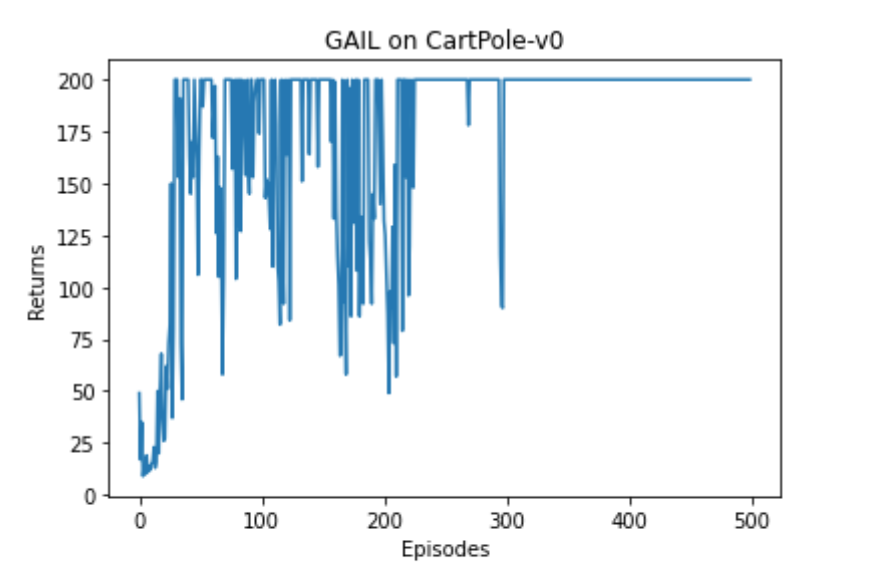

In [8]:
Image(filename='./image/gail_chart.png',width=600)

通过上面两个实验的对比我们可以直观地感受到，**在数据样本有限的情况下，BC 不能学习到最优策略，但是 GAIL 在相同的专家数据下可以取得非常好的结果。**

- 一方面归因于 GAIL 的训练目标（拉近策略和专家的占用度量）十分贴合模仿学习任务的目标，避免了 BC 中的复合误差问题；
- 另一方面得益于 GAIL 训练中，策略可以和环境交互出更多的数据，以此训练判别器，进而生成对基于策略“量身定做”的指导奖励信号。

## 总结

本章还介绍了模仿学习中的两类方法，
- 分别是行为克隆（BC）
- 生成式对抗模仿学习（GAIL）。

**通过实验对比发现，在少量专家数据的情况下，GAIL 能获得更好的效果。**

此外，逆向强化学习（IRL）也是模仿学习中的重要方法，它假设环境的奖励函数应该使得专家轨迹获得最高的奖励值，进而学习背后的奖励函数，最后基于该奖励函数做正向强化学习，从而得到模仿策略。

感兴趣的读者可以查阅相关文献进行学习。